In [1]:
import h5py
import numba as nb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.ndimage.filters
import numpy.linalg
%matplotlib inline

import time

In [2]:
L_box = 205 # in Mpc/h
Nmesh1=256
L_celda=L_box/Nmesh1
#R_Crit200= 60.72031921   
#meanR200=R_Crit200/1000 #mean R_Crit200 de cada corte de masa de los Halos in Mpc/h
#smooth_scale = (4*meanR200)/L_celda
smooth_scale = 20.0
filename = '/Volumes/cosmic_web/DM256/Density256_302.hdf5' #CIC density
f = h5py.File(filename, 'r')
print(f.keys())
data = f['density'][:,:,:]
data_smooth = scipy.ndimage.filters.gaussian_filter(data,smooth_scale)
data = (data - np.mean(data))/np.mean(data)
data_smooth = (data_smooth - np.mean(data_smooth))/np.mean(data_smooth)
print(np.shape(data))
f.close()

print(smooth_scale)

<KeysViewHDF5 ['density']>
(256, 256, 256)
20.0


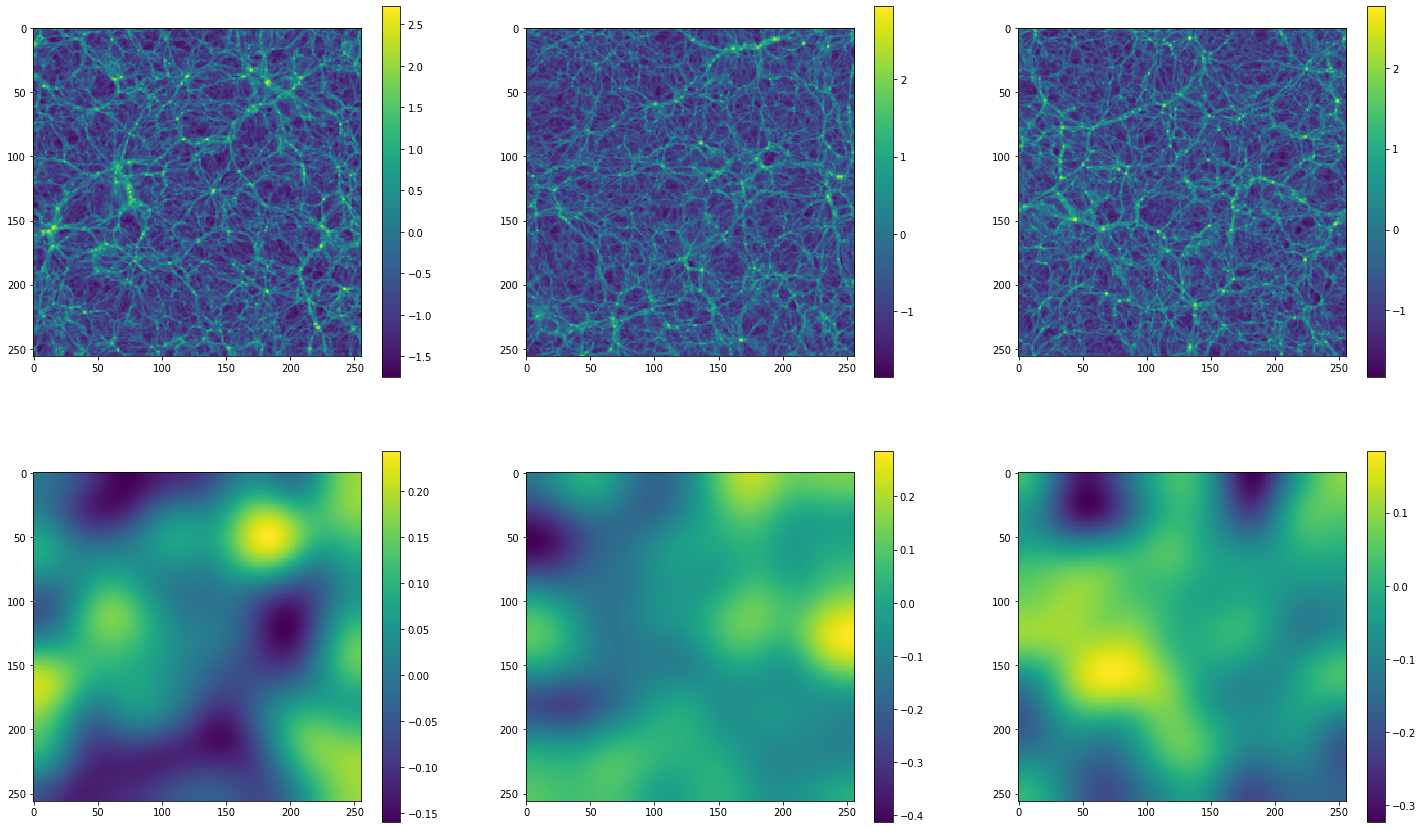

In [3]:
plt.figure(figsize=(25,15))

plt.subplot(2,3,1)
plt.imshow(np.log10(data[:,100,:]+1))
plt.colorbar()

plt.subplot(2,3,2)
plt.imshow(np.log10(data[20,:,:]+1))
plt.colorbar()

plt.subplot(2,3,3)
plt.imshow(np.log10(data[:,:,30]+1))
plt.colorbar()



plt.subplot(2,3,4)
plt.imshow(np.log10(data_smooth[:,100,:]+1))
plt.colorbar()

plt.subplot(2,3,5)
plt.imshow(np.log10(data_smooth[20,:,:]+1))
plt.colorbar()


plt.subplot(2,3,6)
plt.imshow(np.log10(data_smooth[:,:,30]+1))
plt.colorbar()

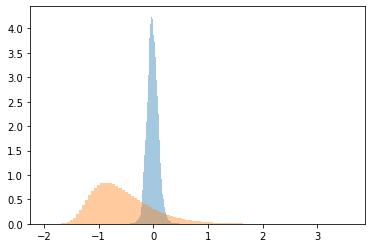

In [4]:
_ = plt.hist(np.log10(np.real(data_smooth[:,:,:].flatten())+1.0), bins=100, alpha=0.4, density=True)
_ = plt.hist(np.log10(np.real(data[:,:,:].flatten())+1.0), bins=100, alpha=0.4, density=True)

In [5]:
fft_lowres = np.fft.fftn(data_smooth)
fft_lowres[0,0,0]=0.0
back_data = np.fft.ifftn(fft_lowres)

In [6]:
from numba import jit


@nb.jit(nopython=True)

def compute(n_side,L_box,delta):  
    k_2_values = np.ones((n_side, n_side, n_side))    
    for i in range(n_side):
        for j in range(n_side):
            for k in range(n_side):
                k_i = i
                k_j = j
                k_k = k
                if i > n_side/2:
                    k_i = n_side - i
                if j > n_side/2:
                    k_j = n_side - j
                if k > n_side/2:
                    k_k = n_side - k
            
                k_2_values[i, j, k] = -(2.0*np.pi*k_i/L_box)**2 + -(2.0*np.pi*k_j/L_box)**2 + -(2.0*np.pi*k_k/L_box)**2
    k_2_values[0, 0, 0] = 1.0
    
    return k_2_values

n_side = np.shape(fft_lowres)[0]
print(n_side)
L_box = 205.0 # in Mpc/h
delta = L_box/n_side

k_2_values=compute(n_side,L_box,delta)


256


In [7]:
fft_potential = fft_lowres/k_2_values
potential = np.fft.ifftn(fft_potential) # este es ahora el potencial reducido
density = scipy.ndimage.filters.laplace(np.real(potential), mode='wrap')/(delta**2) # sanity check

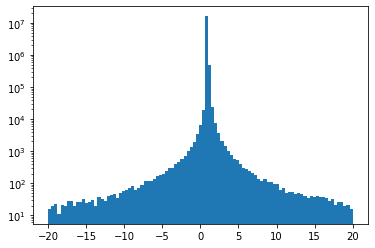

In [8]:
r = data_smooth/density
_=plt.hist(r.flatten(), bins=np.linspace(-20,20,100), log=True)

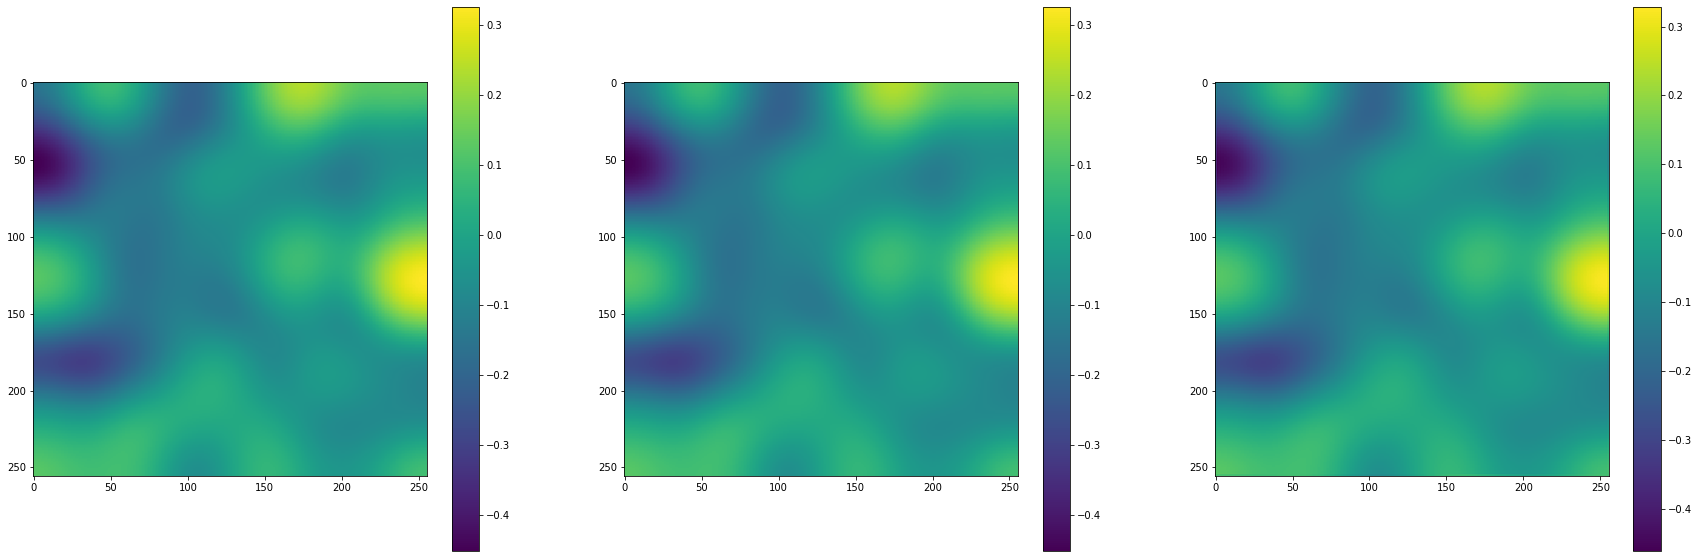

In [9]:
plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
plt.imshow(np.log10(np.real(back_data[10,:,:] + 1)))
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(np.log10(np.real(data_smooth[10,:,:] + 1)))
plt.colorbar()

density[density<-1.0]=-1.0 
plt.subplot(1,3,3)
plt.imshow(np.log10(density[10,:,:] + 1.00))
plt.colorbar()

0


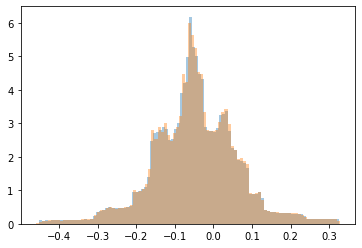

In [10]:
slice_id = 10
#_ = plt.hist(np.log10(np.real(back_data[slice_id,:,:].flatten() + 1)), bins=100, alpha=0.4)
_ = plt.hist(np.log10(np.real(data_smooth[slice_id,:,:].flatten() + 1)), bins=100, alpha=0.4, density=True)
r = density[slice_id,:,:].flatten()
print(np.count_nonzero(density<-1.0))
#r[r<-1.0] = -1.0
_ = plt.hist(np.log10(r + 1.0001), bins=100, alpha=0.4, density=True)

In [11]:
# https://stackoverflow.com/questions/31206443/numpy-second-derivative-of-a-ndimensional-array
def hessian(x):
    """
    Calculate the hessian matrix with finite differences
    Parameters:
       - x : ndarray
    Returns:
       an array of shape (x.dim, x.ndim) + x.shape
       where the array[i, j, ...] corresponds to the second derivative x_ij
    """
    x_grad = np.gradient(x) 
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype=x.dtype) 
    for k, grad_k in enumerate(x_grad):
        # iterate over dimensions
        # apply gradient again to every component of the first derivative.
        tmp_grad = np.gradient(grad_k) 
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
    return hessian

In [12]:
h = hessian(potential)

In [13]:
l = list(data_smooth.shape)
l.append(3)
eigenvector1 = np.empty(l, dtype=data_smooth.dtype)
np.shape(eigenvector1)

(256, 256, 256, 3)

In [14]:
@nb.jit(nopython=True)

def eigen(l,lambda1,lambda2,lambda3,eigenvector1,eigenvector2,eigenvector3):
    for i in range(n_side):
        print(i)
        for j in range(n_side):
            for k in range(n_side):
                local_hessian = np.real(h[:,:,i,j,k])/(delta**2)
                values, vectors = np.linalg.eig(local_hessian)
                ii = np.argsort(values)
                values = values[ii]
                vectors = vectors[ii]
                eigenvector1[i,j,k,:] = vectors[:,2]
                eigenvector2[i,j,k,:] = vectors[:,1]
                eigenvector3[i,j,k,:] = vectors[:,0]
                lambda1[i, j, k] = values[2]
                lambda2[i, j, k] = values[1]
                lambda3[i, j, k] = values[0]
    return lambda1[i, j, k],lambda2[i, j, k],lambda3[i, j, k],i

l = list(data_smooth.shape)
l.append(3)
l=np.array(l)
lambda1 = data_smooth.copy()
lambda2 = data_smooth.copy()
lambda3 = data_smooth.copy()
eigenvector1 = np.empty(l, dtype=data_smooth.dtype)
eigenvector2 = np.empty(l, dtype=data_smooth.dtype)
eigenvector3 = np.empty(l, dtype=data_smooth.dtype)

print(eigen(l,lambda1,lambda2,lambda3,eigenvector1,eigenvector2,eigenvector3))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
(0.3208021819591522, 0.023419389501214027, -0.33704662322998047, 255)


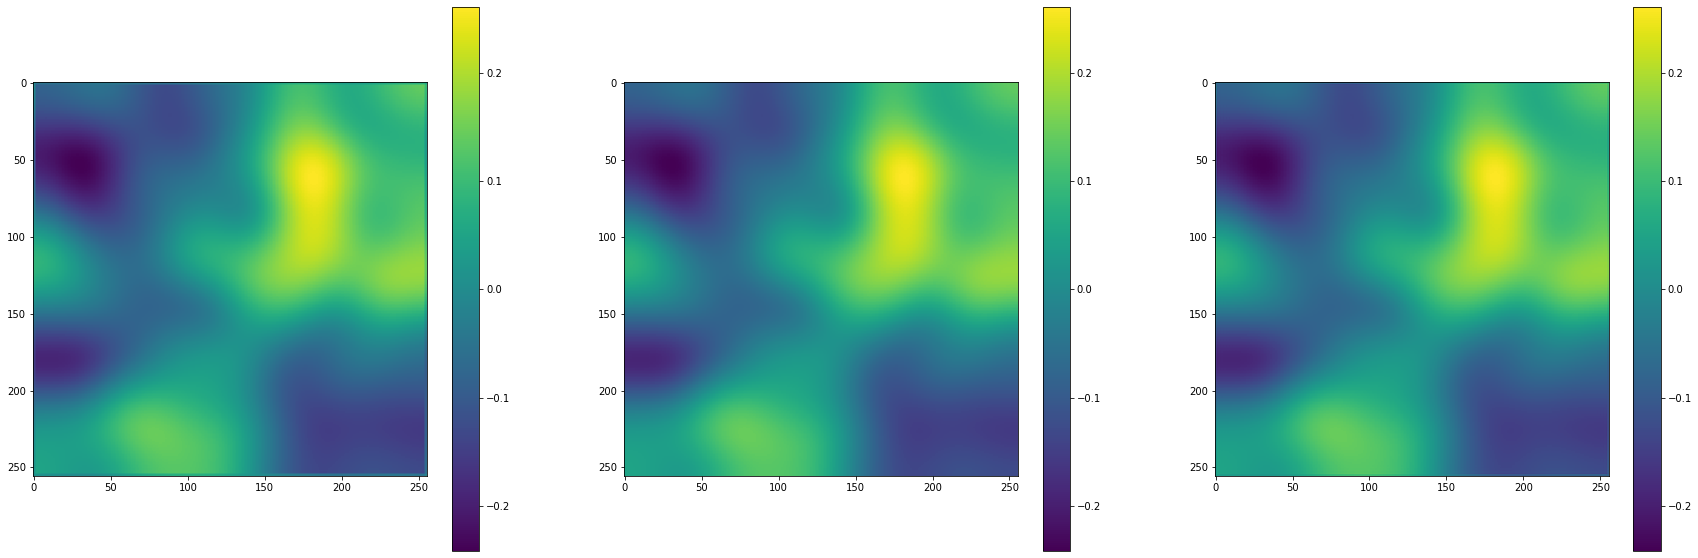

In [15]:
plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
plt.imshow(np.log10(lambda1[40,:,:]+lambda2[40,:,:]+lambda3[40,:,:]+1.))
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(np.log10(np.real(data_smooth[40,:,:] + 1)))
plt.colorbar()

density[density<-1.0]=-1.0 
plt.subplot(1,3,3)
plt.imshow(np.log10(density[40,:,:] + 1.00))
plt.colorbar()

In [16]:
filename = './CosmicWeb_smooth_s{:.2f}.hdf5'.format(smooth_scale)
h5f = h5py.File(filename, 'w')

h5f.create_dataset('density_smooth', data=data_smooth)

h5f.create_dataset('lambda1', data=lambda1)
h5f.create_dataset('lambda2', data=lambda2)
h5f.create_dataset('lambda3', data=lambda3)

h5f.create_dataset('potential', data=np.real(potential))

h5f.create_dataset('hessian', data=h)

h5f.create_dataset('eigenvector1', data=eigenvector1)
h5f.create_dataset('eigenvector2', data=eigenvector2)
h5f.create_dataset('eigenvector3', data=eigenvector3)

h5f.close()